<a href="https://colab.research.google.com/github/a-ramkris/simple-backpropagation/blob/main/simple_backpropagation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline


In [2]:
def f(x):
  return 4*x**2 - 5*x + 4


In [3]:
f(3)

25

In [4]:
xs = np.arange(-10, 10, 0.25)
xs

array([-10.  ,  -9.75,  -9.5 ,  -9.25,  -9.  ,  -8.75,  -8.5 ,  -8.25,
        -8.  ,  -7.75,  -7.5 ,  -7.25,  -7.  ,  -6.75,  -6.5 ,  -6.25,
        -6.  ,  -5.75,  -5.5 ,  -5.25,  -5.  ,  -4.75,  -4.5 ,  -4.25,
        -4.  ,  -3.75,  -3.5 ,  -3.25,  -3.  ,  -2.75,  -2.5 ,  -2.25,
        -2.  ,  -1.75,  -1.5 ,  -1.25,  -1.  ,  -0.75,  -0.5 ,  -0.25,
         0.  ,   0.25,   0.5 ,   0.75,   1.  ,   1.25,   1.5 ,   1.75,
         2.  ,   2.25,   2.5 ,   2.75,   3.  ,   3.25,   3.5 ,   3.75,
         4.  ,   4.25,   4.5 ,   4.75,   5.  ,   5.25,   5.5 ,   5.75,
         6.  ,   6.25,   6.5 ,   6.75,   7.  ,   7.25,   7.5 ,   7.75,
         8.  ,   8.25,   8.5 ,   8.75,   9.  ,   9.25,   9.5 ,   9.75])

In [5]:
ys = f(xs)
ys

array([454. , 433. , 412.5, 392.5, 373. , 354. , 335.5, 317.5, 300. ,
       283. , 266.5, 250.5, 235. , 220. , 205.5, 191.5, 178. , 165. ,
       152.5, 140.5, 129. , 118. , 107.5,  97.5,  88. ,  79. ,  70.5,
        62.5,  55. ,  48. ,  41.5,  35.5,  30. ,  25. ,  20.5,  16.5,
        13. ,  10. ,   7.5,   5.5,   4. ,   3. ,   2.5,   2.5,   3. ,
         4. ,   5.5,   7.5,  10. ,  13. ,  16.5,  20.5,  25. ,  30. ,
        35.5,  41.5,  48. ,  55. ,  62.5,  70.5,  79. ,  88. ,  97.5,
       107.5, 118. , 129. , 140.5, 152.5, 165. , 178. , 191.5, 205.5,
       220. , 235. , 250.5, 266.5, 283. , 300. , 317.5, 335.5])

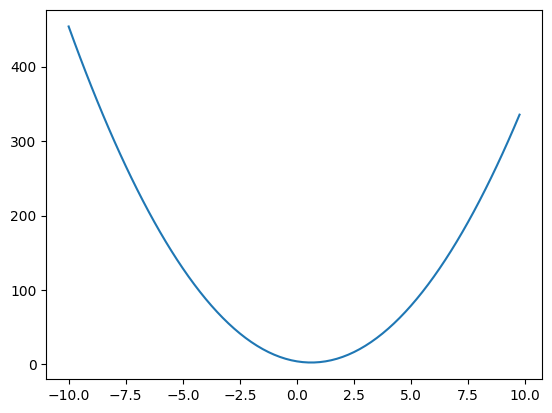

In [6]:
plt.plot(xs, ys)

In [7]:
h = 0.01
x = 3
f(x + h)

25.190399999999997

In [8]:
(f(x+h) - f(x))/h

19.03999999999968

In [9]:
h = 0.01
x = 0
f(x + h)
(f(x+h) - f(x))/h

-4.959999999999987

In [10]:
h = 0.01
x = -3
f(x + h)
(f(x+h) - f(x))/h

-28.959999999999297

In [11]:
a = 2.0
b = -3.0
c = 10

d = a * b + c
print(d)

4.0


In [12]:
h = 0.0001
d1 = a * b + c
d2 = a * (b + h) + c
d3 = (a + h)*b + c
print("Slope with increasing b is", (d2 - d1)/h)
print("Slope with increaseing a is", (d3 - d1)/h)

Slope with increasing b is 2.0000000000042206
Slope with increaseing a is -3.000000000010772


In [142]:
from graphviz import Digraph

def trace(root):
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes,edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.gradient), shape='record')

    if n._op:
      dot.node(name = uid + n._op, label = n._op)
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot



class Value:
  def __init__(self, data, _children=(), _op='', label = ''):
    self.data = data
    #If gradient is 0, there is no effect on output
    self.gradient = 0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = (Value(self.data + other.data, (self, other), '+'))
    def _backward():
      self.gradient += 1.0 * out.gradient
      other.gradient += 1.0 * out.gradient
    out._backward = _backward
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = (Value(self.data * other.data, (self, other), '*'))
    def _backward():
      self.gradient += other.data * out.gradient
      other.gradient += self.data * out.gradient
    out._backward = _backward
    return out

  def __neg__(self):
    return self * -1

  def __sub__(self, other):
    return self + (-other)

  def __rmul__(self,other):
    #This will perform other * self
    return self * other
  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    def _backward():
      self.gradient += (1 - t**2) * out.gradient

    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.gradient += out.data * out.gradient

    out._backward = _backward
    return out

  def __pow__(self, other):
    if isinstance(other, Value):
      other = other.data
    assert isinstance(other, (int, float))
    out = Value(self.data**other, (self, ), f'**other')
    def _backward():
      self.gradient += (other * self.data**(other -1)) * out.gradient
    out._backward = _backward
    return out

  def __truediv__(self, other):
    return self * other**-1

  def __repr__(self):
    return f"Value(data={self.data})"

  def backward(self):
    topo = []
    visited = set()

    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)

    build_topo(self)

    self.gradient = 1.0
    for node in reversed(topo):
      node._backward()

a = Value(2.0, label='a')
b = Value(-3.0, label='b')

print((a + b))
print(a * b)


Value(data=-1.0)
Value(data=-6.0)


In [65]:
c = Value(10.0, label='c')
e = a * b
e.label = 'e'
d = e + c
d.label='d'
print("Value is", d)
#The idea of prev is to store the values from which the current expression is generated
print("Previous to d and the operation are", d._prev, d._op)

Value is Value(data=4.0)
Previous to d and the operation are {Value(data=-6.0), Value(data=10.0)} +


In [66]:
f = Value(-2.0)
f.label = 'f'
L = d * f
#Final Output
L.label = 'L'

x = Value(2.0)
y = Value(4.0)

print((x / y), (y/x), (y**2), (y**x))

Value(data=0.5) Value(data=2.0) Value(data=16.0) Value(data=16.0)


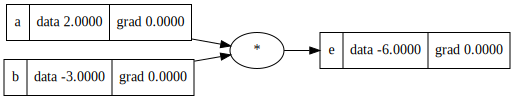

In [67]:
draw_dot(e)

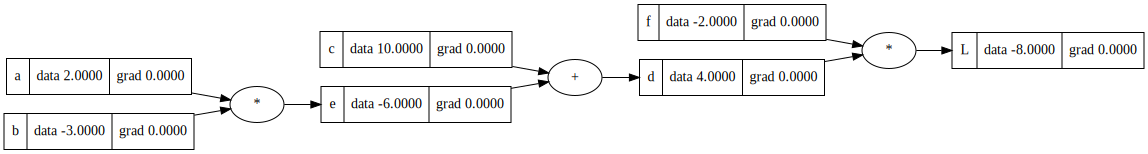

In [68]:
draw_dot(L)

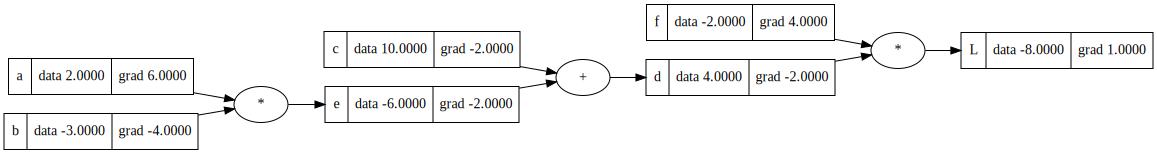

In [69]:
L.gradient = 1.0

d.gradient = -2.0
f.gradient = 4.0

#Chain Rule
#The local derivative of a sum function will be 1.0
#dL/dc = dL/dd * dd/dc
#dL/dc = -2.0 * 1.0 = -2.0

#dL/de = -2.0 * 1.0 = -2.0

#dL/da = dL/dd * dd/de * de/da = -2.0 * 1.0 * -3.0 = 6.0
#dL/db = dL/dd * dd/de * de/db = -2.0 * 1.0 * 2.0 = -4.0

c.gradient = -2.0
e.gradient = -2.0
a.gradient = 6.0
b.gradient = -4.0

draw_dot(L)


In [70]:
#Nudging L
#What we are doing here is to move the value by a tiny bit h
#This will be mathemtically done by multiplying h and derivative of that specific value
h = 0.001

a.data = a.data + h * a.gradient
b.data = b.data + h * b.gradient
c.data = c.data + h * c.gradient
f.data = f.data + h * f.gradient

#e and d are calculated values

e = a * b
d = e + c
L = d * f

print(L.data)

e = a * b
e.label = 'e'
d = e + c
d.label='d'
L = d * f

-7.928064095999999


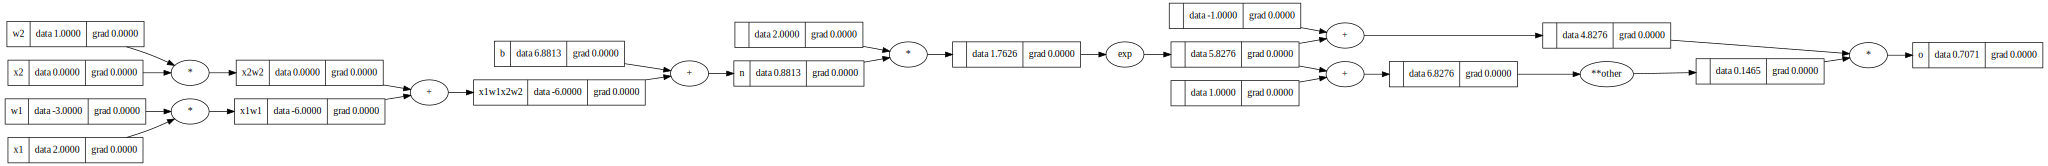

In [71]:
#Backpropagate thru a Neuron

#Activation function is like a squashing function to keep outputs within range

# (weights * inputs) + bias -> Put it thru an activation function

#Inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#Weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

#bias
b = Value(6.8813, label='b')

#x1w1 + x2w2
x1w1 = x1 * w1
x1w1.label = 'x1w1'
x2w2 = x2 * w2
x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1w1x2w2'

n = x1w1x2w2 + b
n.label = 'n'

#Replacing n.tanh() with the granular expression
#o = n.tanh()
e = (2*n).exp()
o = (e - 1) / (e + 1)

o.label = 'o'

draw_dot(o)


In [72]:
#Manual Backpropagation
'''
o.gradient = 1
#do/dn
n.gradient = 1 - o.data**2

b.gradient = n.gradient
x1w1x2w2.gradient = n.gradient
x1w1.gradient = x1w1x2w2.gradient
x2w2.gradient = x1w1x2w2.gradient
x1.gradient = w1.data * x1w1.gradient
w1.gradient = x1.data * x1w1.gradient
w2.gradient = x2.data * x2w2.gradient
x2.gradient = w2.data * x2w2.gradient

draw_dot(n)
'''

'\no.gradient = 1\n#do/dn\nn.gradient = 1 - o.data**2\n\nb.gradient = n.gradient\nx1w1x2w2.gradient = n.gradient\nx1w1.gradient = x1w1x2w2.gradient\nx2w2.gradient = x1w1x2w2.gradient\nx1.gradient = w1.data * x1w1.gradient\nw1.gradient = x1.data * x1w1.gradient\nw2.gradient = x2.data * x2w2.gradient\nx2.gradient = w2.data * x2w2.gradient\n\ndraw_dot(n)\n'

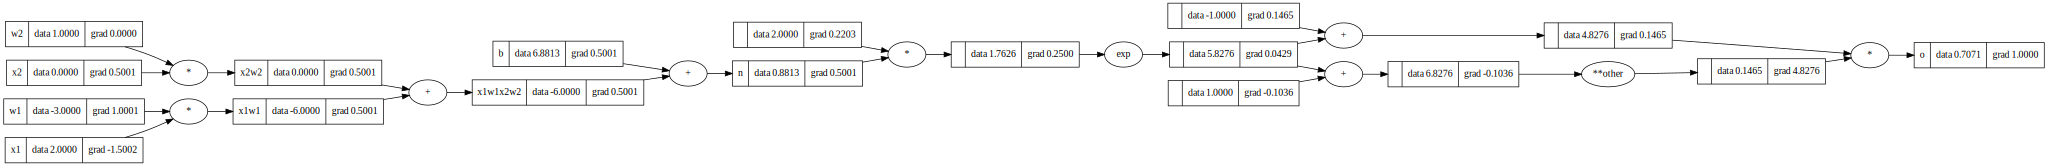

In [73]:
#Backpropagation with the _backward function
o.gradient = 1.0
'''
o._backward()

n._backward()
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()
x1._backward()
w1._backward()
w2._backward()
x2._backward()
'''
o.backward()
draw_dot(o)

In [83]:
import torch
#Implementing in Pytorch
x1 = torch.Tensor([2.0]).double()
x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()
x2.requires_grad = True

w1 = torch.Tensor([-3.0]).double()
w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()
w2.requires_grad = True

b = torch.Tensor([6.8813]).double()
b.requires_grad = True



In [84]:
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)


In [85]:
print(o.data.item())
print(o)


0.7070699720278941
tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)


In [86]:
o.backward()

In [87]:
print('Gradients')
print('x2', x2.grad.item())
print('x1', x1.grad.item())
print('w2', w2.grad.item())
print('w1', w1.grad.item())

Gradients
x2 0.5000520546564731
x1 -1.5001561639694192
w2 0.0
w1 1.0001041093129461


In [156]:
import random
class Neuron(Module):
    def __init__(self, nin, nonlin=True):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(0)
        self.nonlin = nonlin

    def __call__(self, x):
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        return act.tanh()

    def parameters(self):
        return self.w + [self.b]

class Layer(Module):

    def __init__(self, nin, nout, **kwargs):
        self.neurons = [Neuron(nin, **kwargs) for _ in range(nout)]

    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

class MLP(Module):

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1], nonlin=i!=len(nouts)-1) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

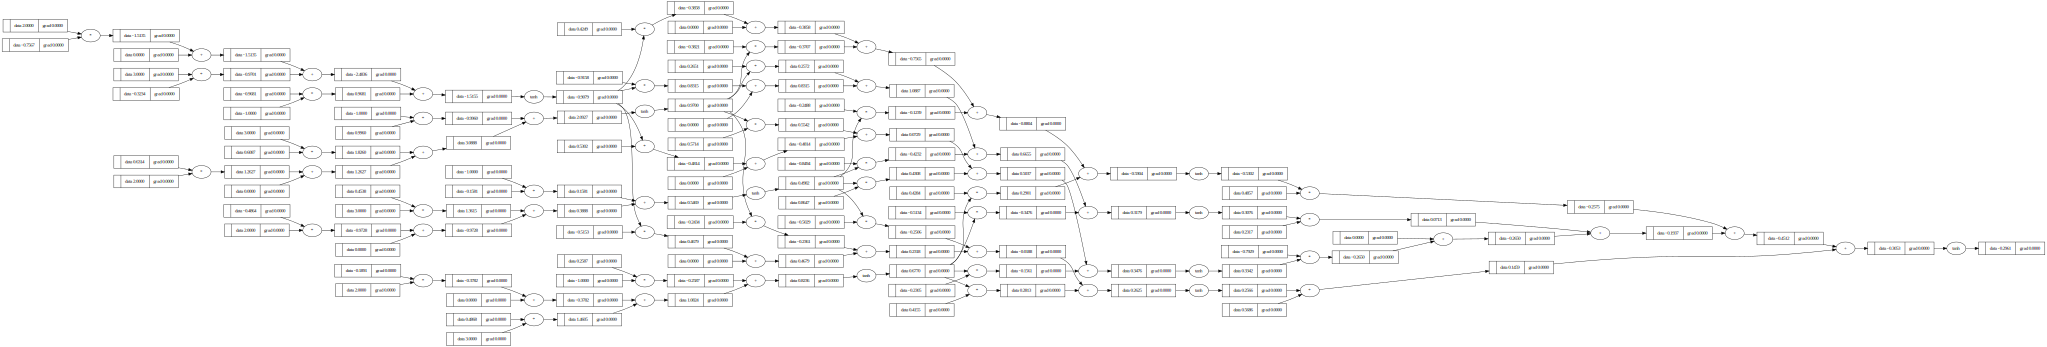

In [157]:
x = [2.0, 3.0, -1]
# 3 inputs
# 2 layers of 4 neurons each
# 1 output
n = MLP(3, [4,4,1])
n(x)

draw_dot(n(x))

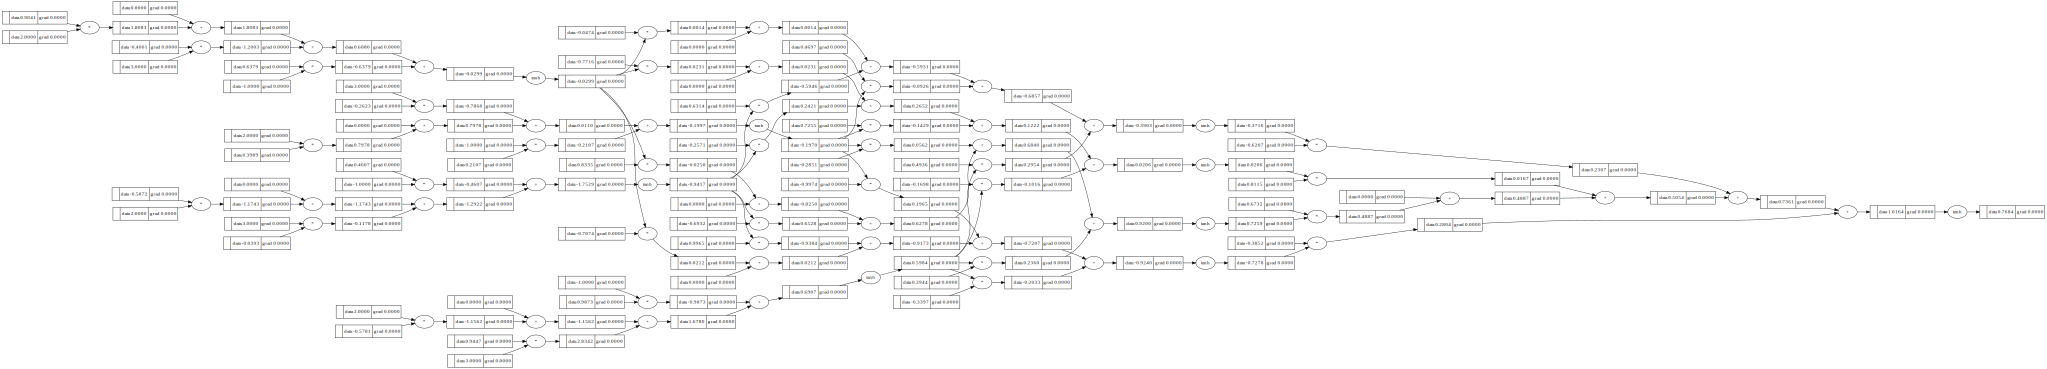

In [158]:
x = [2.0, 3.0, -1]
# 3 inputs
# 2 layers of 4 neurons each
# 1 output
n = MLP(3, [4,4,1])
n(x)

draw_dot(n(x))

In [159]:
#Building a Network and Predicting Values

n = MLP(3, [4, 4, 1])

xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

#This is the expected output
ys = [1.0, -1.0, -1.0, 1.0]

In [160]:
ypred = [n(x) for x in xs]

In [161]:
ypred

[Value(data=0.36300795502481104),
 Value(data=-0.5284176986700503),
 Value(data=-0.21827194812094888),
 Value(data=0.1893304089106014)]

In [162]:
#Loss Function
#Implementing a MSE Loss

loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

In [163]:
loss

Value(data=1.896432665300994)

In [164]:
loss.backward()

In [167]:
print(n.layers[0].neurons[0].w[0].gradient)
print(n.layers[0].neurons[0].w[0].data)
print(n.layers[1].neurons[0].w[0].gradient)
print(n.layers[1].neurons[0].w[0].data)

0.06373694664951929
-0.9924201059420101
0.05816202182833319
-0.018972589916962823


In [168]:
n.parameters()

[Value(data=-0.9924201059420101),
 Value(data=-0.9054453217787566),
 Value(data=0.5806181898702101),
 Value(data=0),
 Value(data=0.019385246614658458),
 Value(data=0.2914003476371301),
 Value(data=-0.7539375151445455),
 Value(data=0),
 Value(data=-0.7916629540104141),
 Value(data=0.6725327909220116),
 Value(data=-0.9844075096194149),
 Value(data=0),
 Value(data=-0.08356333454905474),
 Value(data=-0.6200940539399027),
 Value(data=-0.3178798996387122),
 Value(data=0),
 Value(data=-0.018972589916962823),
 Value(data=-0.17657779981907096),
 Value(data=-0.7890632484528417),
 Value(data=0.49619112023304934),
 Value(data=0),
 Value(data=-0.49316515923780835),
 Value(data=0.5269227839609332),
 Value(data=0.617602720747231),
 Value(data=0.7389121128129394),
 Value(data=0),
 Value(data=0.40905376362142243),
 Value(data=-0.35153607118547425),
 Value(data=0.8931359296925887),
 Value(data=-0.4452095801716156),
 Value(data=0),
 Value(data=0.43630398750227073),
 Value(data=-0.02726638405260795),
 Val

In [171]:
for p in n.parameters():
  p.data += -0.02 * p.gradient

In [170]:
print(n.layers[0].neurons[0].w[0].gradient)
print(n.layers[0].neurons[0].w[0].data)
print(n.layers[1].neurons[0].w[0].gradient)
print(n.layers[1].neurons[0].w[0].data)

0.06373694664951929
-0.9930574754085053
0.05816202182833319
-0.019554210135246154


In [172]:
print(n.layers[0].neurons[0].w[0].gradient)
print(n.layers[0].neurons[0].w[0].data)
print(n.layers[1].neurons[0].w[0].gradient)
print(n.layers[1].neurons[0].w[0].data)

0.06373694664951929
-0.9943322143414957
0.05816202182833319
-0.020717450571812818


In [174]:
print(loss)

Value(data=1.896432665300994)


Value(data=0.04015792128231451)


In [187]:
ypred

[Value(data=0.9463101677386395),
 Value(data=-0.9271994064087475),
 Value(data=-0.8404519495710898),
 Value(data=0.9192546201250084)]

In [254]:
#Inputs & Expected Outputs

n = MLP(3, [5, 5, 1])

xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0]

In [255]:
#Gradient Descent

for k in range(20):
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  for p in n.parameters():
    p.gradient = 0.0

  loss.backward()

  for p in n.parameters():
    p.data += -0.01 * p.gradient

  print(k, loss.data)

print(ypred)

0 1.4013161596285375
1 1.1826553656856187
2 1.0090738903434842
3 0.869961797273396
4 0.7573855744573776
5 0.6653825168759037
6 0.5894530245815024
7 0.5261880024877076
8 0.47299111552184825
9 0.427871886648462
10 0.38929249606988897
11 0.356054854482162
12 0.32721744871914343
13 0.3020339745155253
14 0.2799078375761034
15 0.2603582087961135
16 0.24299451675588435
17 0.22749713229450363
18 0.21360262617302464
19 0.20109242807832267
[Value(data=0.8450291160426996), Value(data=-0.6995577384725193), Value(data=-0.8144040186356832), Value(data=0.7711659282504358)]


In [256]:
#Weights and Biases
print(len(n.parameters()))
n.parameters()

56


[Value(data=-0.7644571951447047),
 Value(data=-0.41027792627545095),
 Value(data=-0.47141334210283475),
 Value(data=0.015609427356204436),
 Value(data=-0.3412774119036081),
 Value(data=0.07168681622651621),
 Value(data=0.8269152261414361),
 Value(data=0.015934297130645796),
 Value(data=-0.34036057710763606),
 Value(data=0.5621967188115384),
 Value(data=-0.7110097539523385),
 Value(data=-0.0064205775461247715),
 Value(data=-0.6779627390663705),
 Value(data=-0.6994332688175963),
 Value(data=0.764128680949127),
 Value(data=0.03657504051410941),
 Value(data=0.8789373404774296),
 Value(data=-0.8211906318508867),
 Value(data=-0.6313151553691019),
 Value(data=-0.02957341235195562),
 Value(data=-0.45266808287844856),
 Value(data=-0.2700147431694025),
 Value(data=-0.6814229569498593),
 Value(data=0.7663371027158116),
 Value(data=-0.33747091759260306),
 Value(data=0.05914336523261738),
 Value(data=-0.3896759802099054),
 Value(data=0.229803974886239),
 Value(data=-0.9503346583963016),
 Value(data